### This notebooke provides the numeric simulation of Quantum lattice gates proposed from Ref: 
### https://www.nature.com/articles/s42005-025-02354-0 (arXiv:https://arxiv.org/abs/2410.17069)


In [7]:
pip install sympy

Defaulting to user installation because normal site-packages is not writeable
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 958.2 kB/s eta 0:00:0000:0100:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# =======================
# 标准库
# =======================
import cmath
import math
import time
from math import factorial, pi, sqrt
from os import listdir
from pathlib import Path

# =======================
# 科学计算与绘图
# =======================
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy
import scipy.io as sio
from scipy.linalg import expm, norm
from scipy.optimize import leastsq, minimize
from scipy.special import (
    gamma,
    gammainc,
    genlaguerre,
    hyp1f1,
    hyp2f1,
    laguerre,
)

# 如果你需要用 np.exp 建议直接写 np.exp，而不是 from numpy import exp
# from numpy import exp  # 如需裸 exp 再打开

# =======================
# JAX
# =======================
import jax
from jax import config, grad, jit, vmap
from jax import numpy as jnp

# =======================
# 优化 / 凸规划 / 并行
# =======================
import cvxpy as cp
from joblib import Parallel, delayed, parallel_backend

# =======================
# 符号计算
# =======================
from sympy import I, KroneckerDelta, exp as sym_exp

# =======================
# QuTiP
# =======================
from qutip import (
    Qobj,
    Options,
    basis,
    coherent,
    destroy,
    displace,
    fidelity,
    fock,
    identity,
    ket2dm,
    mesolve,
    num,
    qeye,
    tensor,
    wigner,
    rand_ket,
)
from qutip.random_objects import (
    rand_super_bcsz,
    rand_kraus_map,
    rand_unitary,
)

# =======================
# 其他设置
# =======================
# matplotlib.use('TkAgg')  # 如需指定后端再打开


In [42]:
#==============================================================
#================useful functions==============================
#==============================================================
def get_fid(psi1,psi2):
    ## return psi fidelity
    return np.abs(np.sum(psi1.conj().T@psi2))**2

def Nj(j,alpha):
    ### Normalization facter for four-legged cat states
    if j ==0 or j==2: # the computation space
        nj = 8*np.exp(-alpha**2)*(np.cosh(alpha**2)+np.cos(alpha**2)*(-1)**(j/2))
    elif j ==1 or j==3: # the error space
        nj = 8*np.exp(-alpha**2)*(np.sinh(alpha**2)+np.sin(alpha**2)*(-1)**((j-1)/2))
    else:
        print('error')
    return nj

def cat_codes(Np,alpha):
    # producing four cat states
    alpa1,alpa2,alpa3,alpa4=coherent(Np,alpha),coherent(Np,-alpha),coherent(Np,1j*alpha),coherent(Np,-1j*alpha)
    psicatc0 = (1/np.sqrt(Nj(0)))*(alpa1+alpa2+alpa3+alpa4)
    psicatc1 = (1/np.sqrt(Nj(2)))*(alpa1+alpa2-alpa3-alpa4)
    psicate0= (1/np.sqrt(Nj(1)))*(alpa1-alpa2-1j*alpa3+1j*alpa4)
    psicate1 = (1/np.sqrt(Nj(3)))*(alpa1-alpa2+1j*alpa3-1j*alpa4)
    rhocatc0,rhocatc1,rhocate0,rhocate1 = ket2dm(psicatc0),ket2dm(psicatc1),ket2dm(psicate0),ket2dm(psicate1)
    return  [psicatc0,psicatc1,psicate0,psicate1],[rhocatc0 ,rhocatc1 ,rhocate0 ,rhocate1]

def binomial_codes(Np):
    return [0.5*(basis(Np,0)+np.sqrt(3)*basis(Np,4)),0.5*(basis(Np,6)+np.sqrt(3)*basis(Np,2))]

def plot_winger_2mod(psi,xvec = np.linspace(-5, 5, 200)):
    ## for flotting the Winger functions
    rho = ket2dm(psi)
    W0 = wigner(rho, xvec, xvec)

    coefficients = psi.full()  # 得到 numpy ndarray，形状为 (N, 1)
    coefficients = np.abs(coefficients)**2#.flatten()  # 转成一维数组
    # 可视化
    fig, axes = plt.subplots(1, 2,figsize=(4.7,2.1))
    c0 = axes[0].contourf(xvec, xvec, W0, 100, cmap='bwr',vmin=-0.5,vmax=0.5)#RdBu_r
    axes[0].set_title(r'$|\psi\rangle$')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('p')
    plt.colorbar(c0, ax=axes[0])

    c1 = axes[1].plot(coefficients)
    axes[1].set_title('Fock PDF')
    axes[1].set_xlabel('Fock')
    axes[1].set_ylabel('Prob')
    plt.tight_layout()
    plt.show()
    return plt

def get_cnm(N,H):
    Hnm = identity( N)*0.0
    cnm_list,indexlist = [],[]
    for n in range( N):
        for m in range( N):
            cnm = complex(H[n,m])
            if np.abs(cnm) >10**-8:
                Hnm += cnm*basis( N,n)*basis( N,m).dag()
                cnm_list.append([cnm,n,m])
                indexlist.append([n,m])
    return Hnm,cnm_list,indexlist


### the Q-function 

In [56]:

def husimi_Q_from_fock(psi_fock, alpha, normalized=False):
    """
    Compute Husimi Q-function for a pure state given in Fock basis.

    Parameters
    ----------
    psi_fock : array_like (complex), shape (N,)
        Fock coefficients c_n of |psi> = sum_n c_n |n>.
    alpha : complex or ndarray of complex
        Phase-space point(s) alpha. Can be a scalar complex or an array (e.g. meshgrid).
    normalized : bool
        If False, normalize psi_fock internally.

    Returns
    -------
    Q : float or ndarray
        Husimi Q(alpha) = (1/pi) * |<alpha|psi>|^2 with same shape as alpha.
    """
    c = np.asarray(psi_fock, dtype=np.complex128)
    if not normalized:
        norm = np.linalg.norm(c)
        if norm == 0:
            raise ValueError("psi_fock has zero norm.")
        c = c / norm

    a = np.asarray(alpha, dtype=np.complex128)
    n = np.arange(c.size)

    # stable sqrt(n!) via log-gamma: n! = exp(gammaln(n+1))
    sqrt_fact = np.exp(0.5 * np.vectorize(np.math.lgamma)(n + 1))

    # <alpha|psi> = exp(-|a|^2/2) * sum_n c_n (a*)^n / sqrt(n!)
    poly = np.zeros_like(a, dtype=np.complex128)
    a_conj = np.conjugate(a)

    # build sum_n c_n (a*)^n / sqrt(n!)
    # (vectorized over alpha; loop only over n, typically small-ish)
    for k in range(c.size):
        poly += c[k] * (a_conj ** k) / sqrt_fact[k]

    overlap = np.exp(-0.5 * (np.abs(a) ** 2)) * poly
    Q = (1.0 / np.pi) * (np.abs(overlap) ** 2)
    return Q


def husimi_Q_grid(psi_fock, xlim=(-4, 4), ylim=(-4, 4), num=201, normalized=False):
    """
    Convenience helper: compute Q on a rectangular grid in alpha = x + i y.

    Returns
    -------
    X, Y : 2D ndarrays
    Q    : 2D ndarray
    """
    xs = np.linspace(xlim[0], xlim[1], num)
    ys = np.linspace(ylim[0], ylim[1], num)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    A = X + 1j * Y
    Q = husimi_Q_from_fock(psi_fock, A, normalized=normalized)
    return X, Y, Q


def plot_Q_function(psi,xvec = (-4, 4)):
    ## for flotting the Winger functions
    X, Y, Q = husimi_Q_grid(psi, xlim=xvec, ylim=xvec, num=201, normalized=False)
    # rho = ket2dm(psi)
    # W0 = wigner(rho, xvec, xvec)

    # coefficients = psi.full()  # 得到 numpy ndarray，形状为 (N, 1)
    # coefficients = np.abs(coefficients)**2#.flatten()  # 转成一维数组
    # 可视化
    fig, axes = plt.subplots(1, 1,figsize=(2.1,1.7))
    c0 = axes.pcolor(X, Y, Q,vmin=0.0,vmax=0.2)#, cmap='bwr'
    axes.set_title(r'$Q(|\psi\rangle)$')
    axes.set_xlabel('x')
    axes.set_ylabel('p')
    plt.colorbar(c0, ax=axes)
    plt.show()
    return plt

### An example: the binomial code preparsion by adiabatic ramping.



### the adiabatical ramping
For a given states $|\psi_{tar}\rangle$, we have target Hamitonian 

$H_{tar}=-\Delta|\psi_{tar}\rangle\langle\psi_{tar}|=\sum_{nm}c_{nm}*\Delta|n\rangle\langle n|$


### the binomial code
$|\psi_{bio}\rangle = \frac{1}{2}(|0\rangle+\sqrt{3}|4\rangle)$.

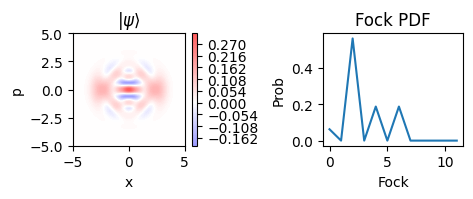

/var/folders/n8/p0f_11tn1hv7jqbpxd31rc640000gn/T/ipykernel_1794/1393038331.py:30: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sqrt_fact = np.exp(0.5 * np.vectorize(np.math.lgamma)(n + 1))


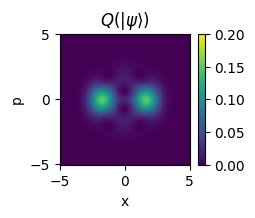

In [57]:
global lamd,alpha,Np,klist,omega0,Dtau,tf,dk, H0,amp
lamd,alpha,Np= 0.25,1.537786,12## sweet spots: 1.537786，2.34474，2.93928，3.43234
omega0 = 1
Dtau= 2 * np.pi / omega0 #2.344#
ki,kf,Nk = 10**(-5),20,20
klist = np.linspace(0, kf, Nk+1)+ ki
dk = klist[1] - klist[0]
H0  = lamd* omega0 * (num(Np) + 0.5)
amp = 0.02

## for a superposition of bionomal code
psi_bio0,psi_bio1 = binomial_codes(Np)
psi_tar =  0.5*(psi_bio0+np.sqrt(3)*psi_bio1)#psi_bio0#

plot_winger_2mod(psi_tar,xvec = np.linspace(-5, 5, 200))
plot_Q_function(psi_tar.full(),xvec = (-5, 5))


Delta = 1
H_tar= -Delta*psi_tar*psi_tar.dag()
_,cnm_list,indices_c =  get_cnm(Np,H_tar)
# Periods = 2000
# tf = Periods * Dtau
# Nt =100
# tlist_finalT = np.linspace(0,tf, Periods*Nt+1)
# dt = tlist_finalT[1]-tlist_finalT[0]

detun =( 1-omega0 / (1 + np.pi * 10 **(-3)))*1 
betaf = 1/40
# betaf = 1/40

In [15]:


###### ===================define functions for constructing the QLGs=================================#
###### ======see anlytic expression in ref:https://www.nature.com/articles/s42005-025-02354-0 =========#
###### ==============Notes:one shall install  reconmmeded python packages (given versions in the folder)=============#


# ### ========== code space components ============

 
def fnm(m,n,k,tau,lamd):  
    # the NcFT coefficient
    if m-n>-1:
        fnm1 = np.exp(0.25*lamd*k**2)*((factorial(m)/factorial(n))**0.5)*(1j*np.exp(1j*tau)*((2/lamd)**0.5)/k)**(n-m)*(lamd/gamma(1+m-n))*hyp1f1(1+m,1+m-n,-0.5*k**2*lamd)
    else:
        fnm1 = np.exp(0.25*lamd*k**2)*((factorial(n)/factorial(m))**0.5)*(1j*np.exp(-1j*tau)* ((2/lamd)**0.5)/k)**(m-n)*(lamd/gamma(1+n-m))*hyp1f1(1+n,1+n-m,-0.5*k**2*lamd)
    return fnm1

def fc(tau,k,cnm_list,phase_err=0.0):
    # the NcFT coefficient for the target states
    rnum = phase_err*np.random.normal(loc=0.0, scale=1)
    fclist1 = np.exp(-1j* rnum)*np.sum([cmn*fnm(m,m1,k,tau,lamd) for cmn,m,m1 in cnm_list])
    return  fclist1

 
def Vnmtc(n, m, tau,cnm_list,phase_err=0.0):
    dk = klist[1]-klist[0]
    
    V_nmt = 0
    if m >= n:
        for k in  klist:
            V_nmt += dk * k * np.exp(-lamd * k ** 2 / 4) * sqrt(factorial(n ) / factorial(m )) * genlaguerre(
                n , m - n)(0.5 * lamd * k ** 2) * np.real(
                 fc(tau,k,cnm_list,phase_err)  * (sqrt(lamd * 0.5) * 1j * k) ** (m - n))
    else:
        for k in  klist:
            V_nmt += dk * k * np.exp(-lamd * k ** 2 / 4) * sqrt(factorial(m ) / factorial(n )) * genlaguerre(
                m , n - m)(lamd * k ** 2 / 2) * np.real(
                 fc(tau,k,cnm_list,phase_err)  * (sqrt(lamd * 0.5) * 1j * k) ** (n - m))
    return V_nmt


def g_fun( t, gf, g0, k, tf, tc):
    c = (gf - g0) / (1 / (1 + np.exp(-k * (tf - tc))) - 1 / (1 + np.exp(k * tc)))
    d = g0 - gf / (1 + np.exp(k * tc))
    return c / (1 + np.exp(-k * (t - tc))) + d

def beta_t( t,tf):
    bf= 1/40
    return g_fun(t, bf, 0, 40 / tf, tf, tf /6)  # (t,0.025,0,40/tf,tf,tf/6)0.025*t/t#

def omega_t(t,tf):
    omega0=1
    return  g_fun(t, 1, omega0 / (1 + np.pi * 10 **(-3)),30/tf,tf,2* tf / 3)

def V_Cat_t(t,cnm_list,phase_err=0.0):
    V0 = np.zeros((Np, Np), dtype='complex128')
    for n in range(Np):
        for m in range(Np):
            V0[n,m] = Vnmtc(n, m, t,cnm_list,phase_err)#+Vnmte(n, m,t,Delta)
    return V0


def get_H(t,cnm_list):

    return  H0.full()+amp*V_Cat_t(t,cnm_list)#

def get_cnm(N,H):
    Hnm = identity( N)*0.0
    cnm_list,indexlist = [],[]
    for n in range( N):
        for m in range( N):
            cnm = complex(H[n,m])
            if np.abs(cnm) >10**-8:
                Hnm += cnm*basis( N,n)*basis( N,m).dag()
                cnm_list.append([cnm,n,m])
                indexlist.append([n,m])
    return Hnm,cnm_list,indexlist
  



(21, 100)


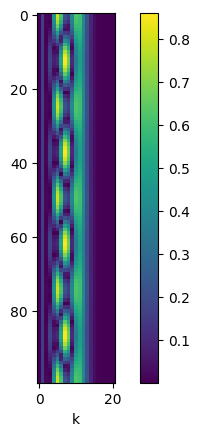

In [ ]:
###=====================================
 
def get_H(t,amp):
    return  H0.full()+ amp*V_Cat_t(t,cnm_list )#
fc_cell= np.array([np.abs(k*fc(t*np.pi*2,k,cnm_list)) for k in klist for t in np.linspace(0,1,100)]).reshape(len(klist),100)
print(np.shape(fc_cell))
plt.imshow(fc_cell.T)
plt.xlabel('t')
plt.xlabel('k')
plt.colorbar()

#### The noise simulation


In numerical simulation, we mimic the experimental noise by introducing the amplitude and phase fluctuation

$\tilde{\beta} (t)\rightarrow {\beta} (t)+\beta_{\mathrm{noise}}\xi(t),$
$\tilde{\Omega} (t)\rightarrow {\Omega} (t)+\omega_{\mathrm{noise}}\xi(t), $

where $\xi(t)$ represents the standard Gaussian noise with average $\langle\xi(t)\rangle=0$ and correlation $\langle\xi(t)\xi(t')\rangle=\delta(t-t')$ with error strength $\beta_{\mathrm{noise}}$ and $\omega_{\mathrm{noise}}$, respectively.



In [ ]:

####=====================================================================================================
####===================================systematic error: the error on the driving fields==================#
####=====================================================================================================

def generate_piecewise_noise(tf, delta_t, noise_p, seed=None):
    """
    在 [0, tf] 区间内，以 delta_t 为间隔，生成 piecewise constant 噪声
    """
    if seed is not None:
        np.random.seed(seed)
    n_steps = int(np.ceil(tf / delta_t))
    noise = np.random.normal(loc=0.0, scale=noise_p, size=n_steps) # scale= Standard deviation, loc= average
    #noise = [np.random.choice([1, -1])*noise_p for sz in range(n_steps)]
    return noise

def noise_func(t, noise_array, delta_t):
    index = int(np.floor(t / delta_t))
    if 0 <= index < len(noise_array):
        return noise_array[index]
    else:
        return 0.0  # 超出时间范围，噪声为 0

def g_fun( t, gf, g0, k, tf, tc):
    c = (gf - g0) / (1 / (1 + np.exp(-k * (tf - tc))) - 1 / (1 + np.exp(k * tc)))
    d = g0 - gf / (1 + np.exp(k * tc))
    return c / (1 + np.exp(-k * (t - tc))) + d

def beta_t( t,tf):
    bf= 1/40
    return g_fun(t, bf, 0, 40 / tf, tf, tf /6)  # (t,0.025,0,40/tf,tf,tf/6)0.025*t/t#

def omega_t(t,tf):
    omega0=1
    return  g_fun(t, 1, omega0 / (1 + np.pi * 10 **(-3)),30/tf,tf,2* tf / 3)


def get_noise_controller(w,p1,p2,tlist_finalT):
    
    detun =( 1-omega0 / (1 + np.pi * 10 **(-3)))*1 
    betaf = 1/40
    t_vals,tf = tlist_finalT,tlist_finalT[-1]
    delta_t = w*2*np.pi
    epsilon1 = p1*betaf
    epsilon2 = p2*detun
    noise1 = generate_piecewise_noise(tf, delta_t, epsilon1 )
    noise2 = generate_piecewise_noise(tf, delta_t, epsilon2 )
    # t = (omega_t(t,tf)+noise_func(t, noise2, delta_t))*t
    beta_vals = [beta_t(t,tf)+noise_func(t, noise1, delta_t) for t in t_vals]
    omega_vals = [omega_t(t,tf)+noise_func(t, noise2, delta_t) for t in t_vals]
    return beta_vals,omega_vals


def get_noise_result(w,p1,p2,tlist_finalT,Vlist,tlist1,Nt):
    ### ====== w: is the noise sample rate: the piecewise noise on time space
    
    
    ### Vlist,tlist1: the V(t) for one period and coresponding time space
    beta_vals,omega_vals = get_noise_controller(w,p1,p2,tlist_finalT)
    dt = tlist_finalT[1]-tlist_finalT[0]
    psi0 = basis(Np, 0)
    U = np.identity(Np)
    Flist = []
    psit = psi0.full()
    i=0
    for t in tlist_finalT:
        t = omega_vals[i]*t#(omega_t(t,tf)+noise_func(t, noise2, delta_t))*t
        beta = beta_vals[i]
        h = H0.full()+beta*Vlist[int((t%Dtau/Dtau)*len(tlist1))]
        psit = expm(-1j*h*dt/lamd)@psit
        if i%Nt==0:
            Flist.append(float(fidelity(Qobj(psit) ,psi_tar)))
        i+=1
    #beta_vals,omega_vals = get_noise_controller(w,p1,p2,tlist_finalT)
    return beta_vals,omega_vals,Flist,psit

def get_V(t,cnm_list):
    return  V_Cat_t(t,cnm_list)#

 

In [ ]:

##========small trick, one shall only computer one-T protential ======##
tlist1 = np.linspace(0,1,4000)*Dtau
Vlist = Parallel(n_jobs=10,verbose=1)(delayed(get_V)(t,cnm_list) for t in tlist1)
np.savez('Vlist_1T.npz',Vlist=Vlist,tlist=tlist1)

fidelity: 0.9982848969373197


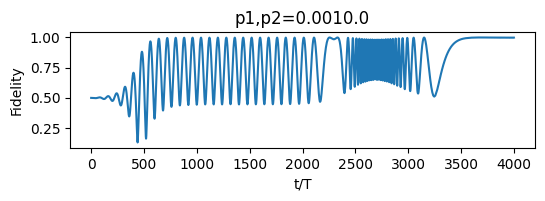

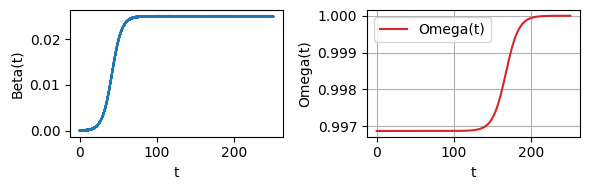

In [ ]:

Periods = 4000
tf = Periods * Dtau
Nt = 100
Np = 10
tlist_finalT = np.linspace(0,tf, Periods*Nt+1)

# =================== for AC noise ===================

Vlist,tlist1 = np.load('Vlist_1T.npz')['Vlist'],np.load('Vlist_1T.npz')['tlist']

##p1: beta noise,p2: Omega noise
p1=0.001
p2=0.00
w= 1/Nt # the sampling rate for noise
beta_noise,omega_noise,Flist,psit=get_noise_result(w=w,p1=p1,p2=p2,tlist_finalT=tlist_finalT,Vlist=Vlist,tlist1=tlist1,Nt=Nt)


plt.figure(figsize=(6,1.5))
plt.title('p1,p2='+str(round(p1,3))+','+str(round(p2,3)))
plt.plot(Flist)
plt.xlabel("t/T")
plt.ylabel("Fidelity")
print('fidelity:',Flist[-1])

plt.figure(figsize=(6, 2))
plt.subplot(1,2,1)
plt.plot(tlist_finalT/Nt, beta_noise, label="Beta(t)", color='tab:blue')
plt.xlabel("t")
plt.ylabel("Beta(t)")
plt.subplot(1,2,2)
plt.plot(tlist_finalT/Nt, omega_noise, label="Omega(t)", color='tab:red')
plt.xlabel("t")
plt.ylabel("Omega(t)")
#plt.title("Beta(t) and Omega(t) with piecewise constant noise every 2π")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()